# Paper Plots and Simple Results

In [1]:
!pwd

/home/sebastian/Computing/GeMSE/results/2025-10-07_LowRad_PMTBases_Resistors_Glue/notebooks


## Loading modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import re
import datetime
import pathlib
import uproot

from adjustText import adjust_text
from uncertainties import ufloat

from gemsepyana import GeMSEData, simple_activities, plot_actvs, which_chain, print_activities_summary

plt.style.use('/home/sebastian/.pltstyle/SR0.mplstyle')

## A few definitions

In [3]:
def get_fn_combined_rootfile(path, verbose=True):
    files = path.glob( "combined_spectra_runs*.root" ) 

    # Check if any files were found
    try:
        # Select the newest file based on modification time
        newest_file = max(files, key=lambda f: f.stat().st_mtime)
        if verbose:
            print(f"The newest combined_spectra is: {newest_file}")
        return newest_file
    except Exception as e:
        if verbose:
            print(f"ERROR: {e}")
            print("ERROR: No combined_spectra file found! Probably data has not been processed using 'GeMSE_ROOT_scripts'")
        return None

In [4]:
def get_bat_parameters_activity_file(path, verbose=True):
    sp = str(path).split("linked_files")
    paf = pathlib.Path( f"{sp[0]}/medium/parameters_activity_calculation.txt" )
    if verbose:
        print (f"  {paf=}\n  {paf.is_file()=}")
    return paf

In [5]:
def get_sample_name(path, verbose=True):
    # Define the regex pattern to match text between "/results/" and "/linked_files/"
    pattern = r'/results/(.*?)/linked_files'
    
    # Search for the pattern in the long string
    match = re.search(pattern, str(path) )
    
    # Check if a match was found
    if match:
        # Return the captured group (the text between the markers)
        if verbose:
            print (f"sample name = {match.group(1)}")
        return match.group(1)
    else:
        if verbose:
            print ("Error: cannot extract name of sample!")
        return None  # Return None if no match is found

In [6]:
def get_run_duration(fn, verbose=True):
    if verbose:
        print (f"trying to extract run duration from {fn=}...")
    pattern = r'_(\d+)s.root'
    match = re.search(pattern, str(fn) )
    if match:
        #run_duration_seconds = match.group(1)
        run_duration_seconds = int( match.group(1) )
        if verbose:
            print (f"{run_duration_seconds=}")
    else:
        run_duration_seconds = None
        if verbose:
            print ("Error: Cannot extract run_duration!")
    return run_duration_seconds

In [7]:
def get_short_name(name, max_length=25):
    _nw = max_length
    if len(name)>_nw:
        _short_name = name.split("_combined")[0]
        if len(_short_name)>_nw:
            _short_name = _short_name[:_nw]
        _short_name += "..."
    else:
        _short_name = name
    return _short_name

In [8]:
def get_run_infos(CHANNEL=0, dir_name=None, verbose=True):
    
    raw_data = {}
    if dir_name is None:
        specp = pathlib.Path( str(pathlib.Path.cwd()).replace("results","spectra").replace("notebooks","DAQ") )
    else:
        specp = pathlib.Path( str(dir_name) )
    assert specp.is_dir()

    
    for _run in sorted(specp.iterdir()):
        _raw = _run.joinpath("RAW")
        if _raw.is_dir():
            _info = sorted(_run.glob("run_*_info.txt"))
            _ch = -1
            if len(_info)>0 and _info[0].is_file():
                with open(_info[0]) as _f:
                    if verbose:
                        print (f"processing file '{_f.name}'...")
                    for line in _f:
                        if line.startswith("CH0@DT5781A_793") or line.startswith("CH0@DT5781A_1363"):
                            _ch=0
                        elif line.startswith("CH1@DT5781A_793") or line.startswith("CH0@DT5781A_1363"):
                            _ch=1
                        elif line.startswith("Run ID"):
                            rname = line.split("=")[1].strip()
                            raw_data[rname]={}
      
                        elif line.startswith("Start time"):
                            tstart = line.split("=")[1].strip()
                            raw_data[rname]["Start time"] = tstart
                            raw_data[rname]["tstart_datetime"] = datetime.datetime.strptime(tstart, "%a %b %d %H:%M:%S %Y")
                        elif line.startswith("Stop time"):
                            tstop = line.split("=")[1].strip()
                            raw_data[rname]["Stop time"] = tstop
                            raw_data[rname]["tstop_datetime"] = datetime.datetime.strptime(tstop, "%a %b %d %H:%M:%S %Y")
                        
                        if not _ch==CHANNEL:
                            #print (f"...inside section 'CH{_ch}; won't fill Real/Live/Dead times...")
                            continue
                          
                        if "Real time" in line: 
                            _trl = line.split("=")[1].strip()
                            _tr = _trl.split(":")
                            _t_real = int(_tr[0])*3600 + int(_tr[1])*60 + float(_tr[2])
                            #print(f"  {_tr=}  {_t_real=}")
                            raw_data[rname]["Real time"] = _t_real
                        elif "Live time" in line:
                            _tll = line.split("=")[1].strip()
                            _tl = _tll.split(":")
                            _t_live = int(_tl[0])*3600 + int(_tl[1])*60 + float(_tl[2])
                            #print(f"  {_tl=}  {_t_live=}")
                            raw_data[rname]["Live time"] = _t_live      
                        elif "Dead time" in line:
                            _tdl = line.split("=")[1].strip()
                            _t_dead = float( _tdl.split("%")[0].strip() )
                            #print(f"  {_tdl=}  {_t_dead=}")
                            raw_data[rname]["Dead time"] = _t_dead 
                        else:
                            pass
                            #print (line)
                _data = sorted(_raw.glob('DataR_CH0*.root'))
                if len(_data)>0 and _data[0].is_file():
                    raw_data[rname]['root_file'] = _data[0]

    total_duration_seconds=0
    for run in raw_data:
            #print (f"raw_data[{run}]={raw_data[run]}")
        duration = (raw_data[run]['tstop_datetime'] - raw_data[run]['tstart_datetime']).total_seconds()
        total_duration_seconds += duration
        if verbose:
            print (f"{run=}:  {duration=}s  (= {duration/(24*3600):.2f} days)  {raw_data[run]['Real time']=}  {raw_data[run]['Dead time']=}%")
            #print (f"  {raw_data[run]["Real time"]=}")

    return raw_data, total_duration_seconds

In [9]:
def get_filenames_and_offsets(runs=None, ftemp = "../linked_files/DataR_CH0@DT5781A_1363_run_{}.root", run_info=None, total_duration_seconds=None, verbose=False):
    if run_info is None:
        raw_data, total_duration_seconds=get_run_infos(verbose=False)
    else:
        raw_data=run_info

    if runs is None:
        runs = [ri.strip("run_") for ri in list(raw_data.keys()) if ri.startswith("run_")]
    fns = []
    t0s = []
    for r in runs:
        fns.append(ftemp.format(r))
        t0s.append( raw_data[f"run_{r}"]['tstart_datetime'] )
    convert_to_timestamp = 1e12
    offsets = [(t0s[i]-t0s[0]).total_seconds()*convert_to_timestamp for i in range(len(t0s))]
    if verbose:
        for i in range(len(runs)):
            print (f"run_{runs[i]}: starts {offsets[i]/1e12/(24*3600):.2f} days after t0")
    return fns, offsets, total_duration_seconds

In [10]:
def readTree(fns, offsets=None, _t_seconds=None, branch_names=["Channel", "Timestamp", "Board", "Energy", "Flags"], tree_name='Data_R'):
    if offsets is None:
        _fns, offsets, _t_seconds = get_filenames_and_offsets()
    if fns is None:
        fns = _fns
    assert len(fns) == len(offsets)
    nEntries_tot = 0
    data = {}
    for i in range(len(fns)):
        fn = fns[i]
        o  = offsets[i]
        print (f"Processing run {i+1}/{len(fns)}, offset by {o/1e12/(24*3600):.2} days")
        with uproot.open(fn) as file:
            tree = file[tree_name]
            for bn in branch_names:
                offset = 0
                if bn == "Timestamp":
                    offset = o
                    nEntries = len(tree[bn].array(library="np"))
                    nEntries_tot += nEntries
                    print (f"  ... {offset=}; {nEntries=}")
                if bn in data: #.keys():
                    data[bn] = np.append( data[bn], tree[bn].array(library="np")+offset )
                    print ('appending...')
                else:
                    data[bn] = tree[bn].array(library="np")+offset
                    #print ('NOT appending...')
    print (f"Total number of Entries: {nEntries_tot}")
    return data, _t_seconds

In [11]:
def ADC2keV(x, p0=0.158873, p1=0.198974, p2=9.30726e-10):
    ## Todo: Read pars from calibration file? E.g. similar to what is done in 
    ## /home/sebastian/Computing/GeMSE/GeMSE_root_scripts/GeMSE_ROOT_scripts/get_calibration_function.cxx
    return p0+p1*x+p2*x*x

In [12]:
def keV2ADC(x, p0=0.158873, p1=0.198974, p2=9.30726e-10):
    ## numerically invert poly2 using "p,q"-formula
    p = p1/p2
    q = (p0-x)/p2
    _r = np.sqrt( (p/2)**2 - q )
    _res =  (-p/2 + _r , -p/2 - _r)
    return _res[0] # _res[1] typically negative and not the searched-for solution

In [13]:
def myhist(data, erange, label, alpha, xaxis="keV", sumbins=10.):
    # 0. transform erange to adcrange
    # 1. compute proper number of bins nb
    # 2. bin data e.g. using np.histogram and nb bins
    # 3. compute bin_edges_kev from bin_edges_adc
    # 4. plot histogram using bin_edges_kev
    erange=np.array(erange)
    adcrange = keV2ADC(erange)
    nb = round ( (adcrange[1]-adcrange[0]+1)/sumbins ) 
    _n_adc, _bin_edges_adc = np.histogram(data, bins=nb, range=adcrange) # do histogram in ADC space

    if xaxis == "ADC":
        _n, _be, _p = plt.gca().hist(_bin_edges_adc[:-1], _bin_edges_adc, weights=_n_adc, alpha=alpha, label=label)
    elif xaxis == "keV":
        _bin_edges_keV = ADC2keV(_bin_edges_adc)
        _bin_width = np.diff(_bin_edges_keV)
        _n, _be, _p = plt.gca().hist(_bin_edges_keV[:-1], _bin_edges_keV, weights=_n_adc/_bin_width, alpha=alpha, label=label)
    else:
        print ("Error. Only keywords 'keV' or 'ADC' allowed for xaxis parameter!")
        assert 1 == 0
    
    return _n, _be, _p

In [14]:
def gbc(bins):
    """
    Compute the bin centers from the bin edges.

    Parameters:
    bins (array-like): The edges of the bins returned by plt.hist.

    Returns:
    np.ndarray: The centers of the bins.
    """
    return 0.5 * (bins[:-1] + bins[1:])

In [15]:
def load_raw_spectrum(fns=None, offsets=None, duration_days=None, erange=[10, 3100], sumbins=1,
                      branch_names=["Channel", "Timestamp", "Board", "Energy", "Flags"], 
                      tree_name='Data_R', only_flags=['0x0', ]):
    ## these quantities we have to provide:
    # 173         self.x = bc[xlim]
    # 174         self.y = h_cont[xlim]
    # 175         self.yerr = hist.errors()[xlim]
    # 176         self.binwidth = bw[xlim]
    # 178         self.y_per_keV_per_day = self.norm_cts_kev_day()
    # 179 
    # 180         ## keep original histogram in case of rebinning
    # 181         self.x_orig = self.x
    # 182         self.y_orig = self.y
    # 183         self.bw_orig = self.binwidth
    # 184         self.ynorm_orig = self.y_per_keV_per_day
    _d, _t_seconds = readTree(fns=fns, offsets=offsets, branch_names=branch_names, tree_name=tree_name) 

    if duration_days is None:
        duration_days=_t_seconds/(24*3600)
    
    Xf = (_d["Energy"] > -10) # should always be True
    for ofl in only_flags:
        ofl = int(ofl, 16) # ofl is a hex string!
        Xf = Xf & (_d["Flags"] == ofl)
    
    data = _d["Energy"][Xf] 
    
    erange=np.array(erange)
    adcrange = keV2ADC(erange)
    nb = round ( (adcrange[1]-adcrange[0]+1)/sumbins ) 
    _n_adc, _bin_edges_adc = np.histogram(data, bins=nb, range=adcrange) # do histogram in ADC space

    _bin_edges_keV = ADC2keV(_bin_edges_adc)
    _bin_width = np.diff(_bin_edges_keV)
    _n_per_keV, _be = np.histogram(_bin_edges_keV[:-1], _bin_edges_keV, weights=_n_adc/_bin_width)

    _bc = gbc(_be)
    _n_per_keV_per_day = _n_per_keV/duration_days

#    return self.x, self.y, self.yerr, self.binwidth, self.y_per_keV_per_day, self.t_live
    return _bc, _n_adc, np.sqrt(_n_adc), _bin_width, _n_per_keV_per_day, _t_seconds   

## Loading the data

In [16]:
lfs = pathlib.Path( str(pathlib.Path.cwd()).replace("notebooks","linked_files") )
lfs.is_dir()

True

In [17]:
# In case you want to load a differnent file than the newest in the current folder:
# lfs = pathlib.Path( "/home/sebastian/Computing/GeMSE/results/2025-09-03_Leyden_Alu_after_cutting_cubes/notebooks".replace("notebooks","linked_files") )
# lfs.is_dir()

In [18]:
# bg file
bg = GeMSEData()
bg.fn = '/home/sebastian/Computing/GeMSE/analysis_input_files/background/2019-2020_combined_background/2019-2020_combined_bkg_calibrated.root.root'
bg.sample_name = 'Background (2020)'
bg.t_live = 9.48034e+06 # in seconds

bg.load_spectrum()
bg.rebin(nbins=3)

Will now load file:  /home/sebastian/Computing/GeMSE/analysis_input_files/background/2019-2020_combined_background/2019-2020_combined_bkg_calibrated.root.root


In [19]:
# sample
sample = GeMSEData()
#sample.fn = '/home/sebastian/Computing/GeMSE/results/2025-09-03_Leyden_Alu_after_cutting_cubes/linked_files/combined_spectra_runs_1_2_3_4_5_6_1002189s.root'
sample.fn = get_fn_combined_rootfile( path=lfs )

sample.sample_name = get_sample_name( path=lfs )
# put you favorite name here:
#sample.sample_name = r'Al Leyden (4.18 kg)'
sample.t_live = get_run_duration(fn=sample.fn, verbose=False) # in seconds
#sample.t_live = 1002189# in seconds

sample.load_spectrum()
sample.rebin(nbins=3)

The newest combined_spectra is: /home/sebastian/Computing/GeMSE/results/2025-10-07_LowRad_PMTBases_Resistors_Glue/linked_files/combined_spectra_runs_1_2_3_4_494237s.root
sample name = 2025-10-07_LowRad_PMTBases_Resistors_Glue
Will now load file:  /home/sebastian/Computing/GeMSE/results/2025-10-07_LowRad_PMTBases_Resistors_Glue/linked_files/combined_spectra_runs_1_2_3_4_494237s.root


## Plotting the data for visualization

In [22]:
#c_sample = 'xkcd:poop green'
#c_sample = 'xkcd:lipstick'
#c_bg = 'xkcd:tangerine'
#c_sample = 'xkcd:royal blue'

c_sample = "xkcd:eggplant"
#c_bg  = 'xkcd:grape'
#c_bg = 'xkcd:carnation'
c_bg = 'xkcd:lipstick'
c_bg = 'xkcd:perrywinkle'

Drawing lines with isotopes=('Pb212', 'Bi212') and minBR=None


/tmp/ipykernel_51345/166226645.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


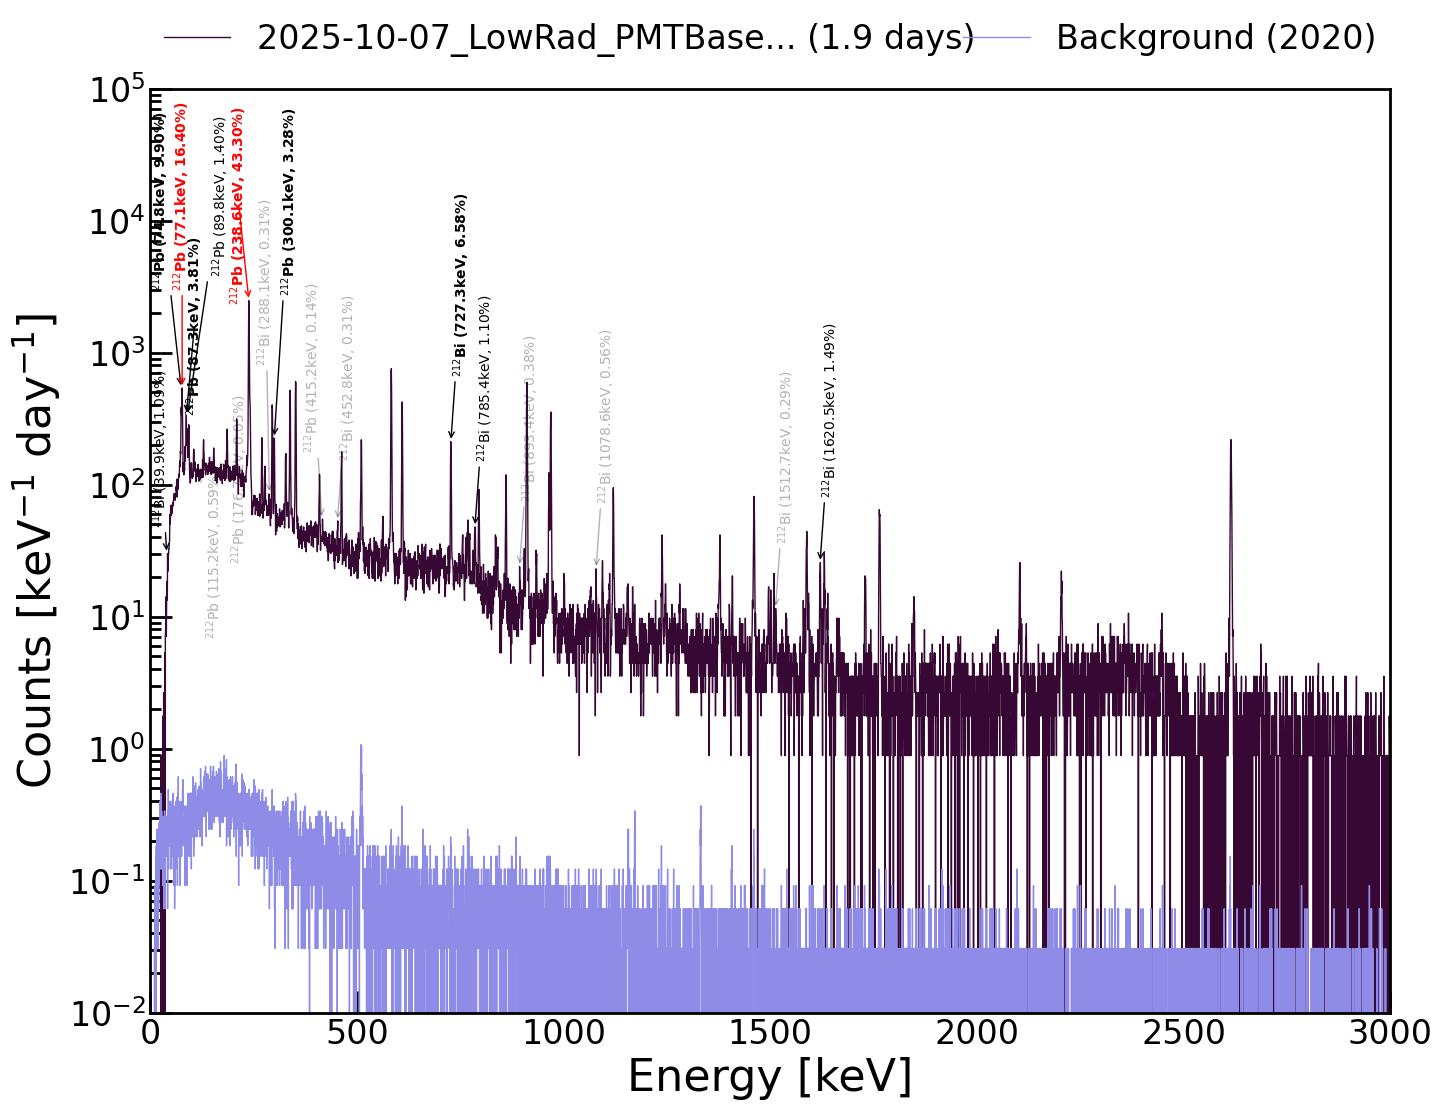

In [25]:
minBR = None # 0.01 #None # 0.1 #0.5# 0 #5
isotope = ("Tl208", "Pb214", "Bi214")
isotope = ("Pb212", "Bi212")

#isotope = iso_list
#isotope = ("U238", "Th228", "Tl208", "Pb212", "234mPa")
#isotope = ("234mPa")

fig, ax = plt.subplots(figsize=(16,12))

xrange = (0,3000)
sample_lab = f"{get_short_name(name=sample.sample_name)} ({sample.t_live/(3600*24):.1f} days)"

ax.plot(sample.x , sample.y_per_keV_per_day , '-', c=c_sample, lw=1, label=sample_lab)
ax.plot(bg.x, bg.y_per_keV_per_day, '-', c=c_bg, lw=1, label=bg.sample_name)

print (f"Drawing lines with isotopes={isotope} and minBR={minBR}")

ax.set_ylabel(r'Counts [keV$^{-1}$ day$^{-1}$]')
ax.set_xlabel('Energy [keV]')
ax.set_yscale('log')
ax.set_xlim(*xrange)
ax.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), 
          loc="lower left",
          mode="expand", 
          borderaxespad=0,
          frameon=False, 
          ncol=2)

annots = sample.annotate_lines(
      sdict = sample.manual_dict, ## put cuts on manual dict, to select important lines
      xrange=xrange,
      minBR = minBR, 
      isotope=isotope,
      fontsize=10,
      adjustTextLabels=False,
      #padding=100,
      #pixel_offset = (0, 50),
      #drawVLines=False, 
)

ax.set_ylim(1e-2,1e5)

if True:
  adjust_text( annots, ax=plt.gca() ) #, only_move={'text':'y+'} )  ## this is an interesting feature...

fig.show()
#plt.savefig(outputfile)

In [25]:
iso_list = ["U238", "Ra226", "Th228", "Ra228", "K40", "Co57",]

# Looking into rates

In [25]:
sample.load_bat_params(fn=get_bat_parameters_activity_file(path=lfs))

  paf=PosixPath('/home/sebastian/Computing/GeMSE/results/2025-10-07_LowRad_PMTBases_Resistors_Glue/medium/parameters_activity_calculation.txt')
  paf.is_file()=True
Called 'load_bat_params(fn= /home/sebastian/Computing/GeMSE/results/2025-10-07_LowRad_PMTBases_Resistors_Glue/medium/parameters_activity_calculation.txt ')
Calling 'get_efficiencies' ...


source: /opt/GeMSE/root/bin/thisroot.sh:158:13: parameter expansion requires a literal


Efficiencies loaded.
0.000637495
0.0006021
0.000934055
0.00138296
0.00127833
0.00209123
0.00136954
0.00118817
0.00148311
0.00281177
0.00138006
0.000681275
0.00038474
0.00166219
0.000550014
0.000599269
0.00092107
0.00303152
0.000625998
0.000826556
0.000531765
0.000501471
0.000641022
0.000633993
0.00264799
0.000466649
0.000566304
0.000533746
0.000444264
0.000639361
0.000485221
0.000581722
0.000533557
0.000396228
0.00052126
0.000514257
0.000473036
0.00067679
0.00352604
0.000784679
0.000851926
0.000594895
0.000701625
0.000614715
0.000610352
0.000496286
0.00337303
... Efficiencies: 
Th228 :  {238.6: (0.0340064, 0.0006017071650157315), 583.2: (0.0117425, 0.0002081224114359896), 727.3: (0.00268865, 0.00018754503667860756), 2614.5: (0.00528251, 0.00013793523301932893)}
U238 :  {63.3: (0.000118114, 0.00012480172961644968), 92.6: (0.00169369, 2.696600665709291e-05), 1001.0: (0.000305036, 5.069689478986958e-06)}
Ti44 :  {67.9: (0.00863537, 0.00036849220215522533), 78.3: (0.0203925, 0.000502495724

source: /opt/GeMSE/root/bin/thisroot.sh:158:13: parameter expansion requires a literal


  Successfully set resolution_function. (sqrt(([p0]+([p1]*x))+([p2]*(x*x))), sqrt((0.239167+(0.000282834*x))+(2.32708e-08*(x*x))))
self.resolution_function(10)=0.492
BAT parameters loaded.
  Bat_params: {'sample name': ['2025-10-07_LowRad_PMTBases_Resistors_Glue'], 'accuracy of MCMC (low/medium/high)': ['medium'], 'threshold on Bayes Factor for signal detection': ['0.33'], 'CL for activity limit': ['0.95'], 'fractional uncertainty of efficiencies': ['0.02'], 'isotope parameters folder': ['/home/sebastian/Computing/GeMSE/GeMSE_analysis/GeMSE_analysis/data/example/isotope_parameters'], 'sample spectrum file name': ['/home/sebastian/Computing/GeMSE/results/2025-10-07_LowRad_PMTBases_Resistors_Glue/linked_files/combined_spectra_runs_1_2_3_163661s.root'], 'background spectrum file name': ['/home/sebastian/Computing/GeMSE/bkg_data/bkg_data/2019-2020_combined_background/2019-2020_combined_bkg_calibrated.root.root'], 'efficiency file name': ['/home/sebastian/Computing/GeMSE/my_mc_results/2023-

---------
Th228: 238.6 keV; eff=3.40(6)%; a=1.655(35)Bq (left:1.705(35)Bq; right:1.604(35)Bq)
Th228: 583.2 keV; eff=1.174(21)%; a=1.55(4)Bq (left:1.55(4)Bq; right:1.56(4)Bq)
Th228: 727.3 keV; eff=0.269(19)%; a=1.73(14)Bq (left:1.65(14)Bq; right:1.80(14)Bq)
Th228: 2614.5 keV; eff=0.528(14)%; a=1.56(6)Bq (left:1.56(6)Bq; right:1.56(6)Bq)
---------
U238: 63.3 keV; eff=0.012(12)%; a=-0.2(1.7)Bq (left:5.0(1.7)Bq; right:-6.1(1.7)Bq)
U238: 92.6 keV; eff=0.1694(27)%; a=0.56(17)Bq (left:-1.22(17)Bq; right:2.33(17)Bq)
U238: 1001.0 keV; eff=0.0305(5)%; a=1.14(29)Bq (left:1.08(29)Bq; right:1.20(29)Bq)
---------
K40: 1460.8 keV; eff=0.300(18)%; a=0.84(7)Bq (left:0.84(7)Bq; right:0.84(7)Bq)
---------
Cs137: 661.7 keV; eff=3.89(6)%; a=-0.0004(32)Bq (left:0.0009(32)Bq; right:-0.0019(32)Bq)
---------
Ra226: 295.2 keV; eff=1.32(4)%; a=0.460(27)Bq (left:0.590(27)Bq; right:0.344(27)Bq)
Ra226: 351.9 keV; eff=2.31(5)%; a=0.616(20)Bq (left:0.614(20)Bq; right:0.619(20)Bq)
Ra226: 609.3 keV; eff=1.75(4)%; a=0.5

/home/sebastian/Computing/GeMSE/GeMSE_python_tools/gemsepyana/gemsepyana/helpers.py:268: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


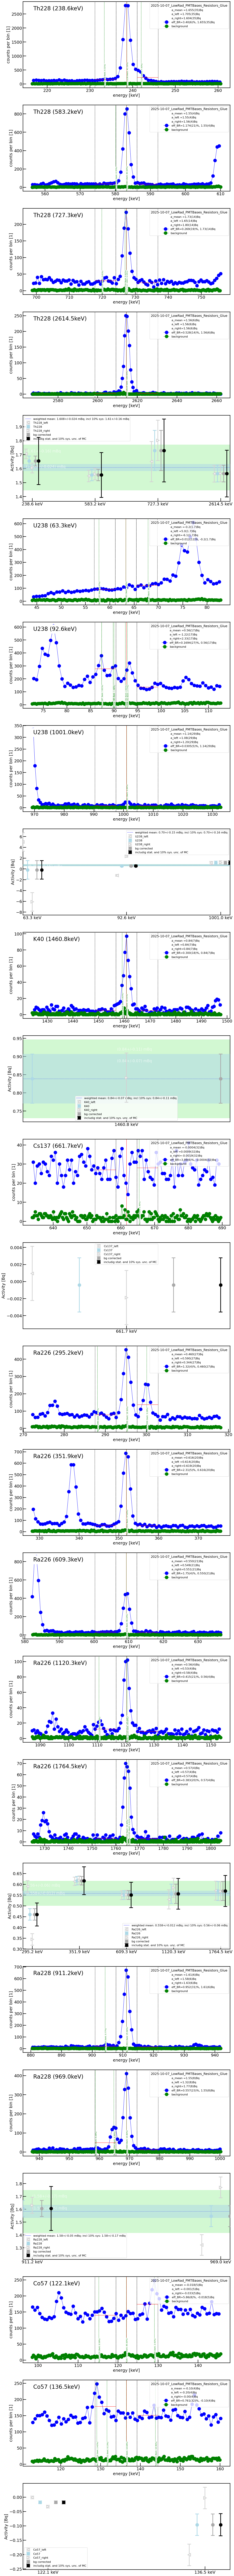

In [26]:
#iso_list = None # ["Ra226", ]
iso_list = ["U238","Ra226","Th228","Ra228","K40", "Co57", "Cs137" ]
#iso_list = ["Th228","Ra226", ]

actvs, als = simple_activities(gd=sample, plot=True, isotopes=iso_list, yscale='linear', bg=bg, show_summary=True, ignore_outliers=False )

### Print the results

In [27]:
res = print_activities_summary(als=als) # , exclude={}, ignore_outliers=True)

     Th228:  1.608(24) Bq 	-> 1.61(16) Bq
      U238:  0.70(15) Bq 	-> 0.70(16) Bq
       K40:  0.84(7) Bq 	-> 0.84(11) Bq
     Cs137: Weights sum to zero, can't be normalized
     Ra226:  0.558(12) Bq 	-> 0.56(6) Bq
     Ra228:  1.58(5) Bq 	-> 1.58(17) Bq
      Co57: Weights sum to zero, can't be normalized


In [19]:
sample.sample_name

'2025-09-22_Leyden_Alu_after_cutting_cubes_afterHardReboot'

In [20]:
## save the result for later comparision to other measurement
import pickle
with open(f'{sample.sample_name}.pickle', 'wb') as handle:
    pickle.dump(res, handle, protocol=pickle.HIGHEST_PROTOCOL)